We continue examining the diffusion of tetracycline among doctors in Illinois in the early 1950s, building on our work in lab 6.  You will need the data sets `ckm_nodes.csv` and `ckm_network.dat` from the labs.

1. Clean the data to eliminate doctors for whom we have no adoption-date information, as in the labs.  Only use this cleaned data in the rest of the assignment.

In [20]:
library(tidyverse)
library(ggplot2)
ckm_nodes <- read_csv("data/ckm_nodes.csv")
noinfor <- which(is.na(ckm_nodes$adoption_date))
ckm_nodes <- ckm_nodes[-noinfor, ]
ckm_network <- read.table("data/ckm_network.dat")
ckm_network <- ckm_network[-noinfor, -noinfor]

ckm_nodes


Rows: 246 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): city, medical_school, attend_meetings, free_time_with, discuss_med...
dbl  (3): adoption_date, medical_journals, drs_among_three_best_friends

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


city,adoption_date,medical_school,attend_meetings,medical_journals,free_time_with,discuss_medicine_socially,club_with_drs,drs_among_three_best_friends,practicing_here,office_visits_per_week,proximity_to_other_drs,specialty
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
Peoria,1,1920--1929,specialty,9,non-doctors,no,no,0,20+ years,101--150,in_building_and_office,pediatrician
Peoria,12,1945+,none,5,doctors,yes,no,3,1- year,76--100,in_building_and_office,GP
Peoria,8,1935--1939,general,7,doctors,no,no,2,10--20 years,76--100,in_building_but_not_office,internist
Peoria,9,1940--1944,general,6,non-doctors,no,no,0,5--10 years,51--75,in_building_and_office,GP
Peoria,9,1935--1939,general,4,non-doctors,yes,no,1,10--20 years,51--75,in_building_but_not_office,GP
Peoria,10,1930--1934,none,7,split,yes,no,0,10--20 years,101--150,in_building_and_office,internist
Peoria,Inf,1919-,none,3,non-doctors,yes,no,0,20+ years,151+,in_building_but_not_office,GP
Peoria,3,1935--1939,none,9,split,yes,no,0,10--20 years,151+,not_in_building,GP
Peoria,11,1920--1929,specialty,5,non-doctors,no,no,0,20+ years,25-,in_building_but_not_office,pediatrician


2. Create a new data frame which records, for every doctor, for every month, whether that doctor began prescribing tetracycline that month, whether they had adopted tetracycline before that month, the number of their contacts who began prescribing strictly _before_ that month, and the number of their contacts who began prescribing in that month or earlier.  Explain why the dataframe should have 6 columns, and 2125 rows. 

**Answer**:

The dataframe should have 6 columns because it should include the following information for each records:

- `doctor_id`: The unique identifier for each doctor.
- `month`: The month in which the data is recorded.
- `adopted_this_month`: A boolean indicating whether the doctor adopted tetracycline in that month.
- `adopted_before`: A boolean indicating whether the doctor had adopted tetracycline before that month.
- `contacts_before`: The number of contacts who adopted tetracycline strictly before that month.
- `contacts_before_or_same`: The number of contacts who adopted tetracycline in that month or earlier.

The dataframe should have 2125 rows because there are 125 doctors and 17 months in total, resulting in \(125 \times 17 = 2125\) unique combinations of doctors and months.

In [ ]:
finite_dates <- ckm_nodes$adoption_date[is.finite(ckm_nodes$adoption_date)]
min_month <- min(finite_dates)
max_month <- max(finite_dates)
months <- min_month:max_month

n_doctors <- nrow(ckm_nodes)
n_months <- length(months)

doctor_month_df <- data.frame(
    doctor_id = rep(1:n_doctors, each = n_months),
    month = rep(months, times = n_doctors),
    started_this_month = FALSE,
    adopted_before = FALSE,
    contacts_before = 0,
    contacts_before_or_same = 0
)

for (i in 1:n_doctors) {
    doctor_adoption_month <- ckm_nodes$adoption_date[i]

    contacts <- which(ckm_network[i, ] == 1)

    for (j in 1:n_months) {
        current_month <- months[j]
        row_idx <- (i - 1) * n_months + j

        if (is.finite(doctor_adoption_month)) {
            doctor_month_df$started_this_month[row_idx] <- (doctor_adoption_month == current_month)
            doctor_month_df$adopted_before[row_idx] <- (doctor_adoption_month < current_month)
        }

        contacts_before_count <- 0
        contacts_before_or_same_count <- 0

        for (contact in contacts) {
            contact_adoption_month <- ckm_nodes$adoption_date[contact]
            if (is.finite(contact_adoption_month)) {
                if (contact_adoption_month < current_month) {
                    contacts_before_count <- contacts_before_count + 1
                }
                if (contact_adoption_month <= current_month) {
                    contacts_before_or_same_count <- contacts_before_or_same_count + 1
                }
            }
        }

        doctor_month_df$contacts_before[row_idx] <- contacts_before_count
        doctor_month_df$contacts_before_or_same[row_idx] <- contacts_before_or_same_count
    }
}

head(n = 10, doctor_month_df)


,doctor_id,month,started_this_month,adopted_before,contacts_before,contacts_before_or_same
,<int>,<int>,<lgl>,<lgl>,<dbl>,<dbl>
1,1,1,TRUE,FALSE,0,1
2,1,2,FALSE,TRUE,1,1
3,1,3,FALSE,TRUE,1,2
4,1,4,FALSE,TRUE,2,3
5,1,5,FALSE,TRUE,3,3
6,1,6,FALSE,TRUE,3,3
7,1,7,FALSE,TRUE,3,3
8,1,8,FALSE,TRUE,3,3
9,1,9,FALSE,TRUE,3,3


3.  Let

$$
\begin{equation}
\begin{split}
p_k & = \Pr(\text{A doctor starts prescribing tetracycline this month} \mid \\
    & \text{Number of doctor's contacts prescribing before this month}=k) 
\end{split}
\end{equation}
$$
and
$$
\begin{equation}
\begin{split}
q_k & = \Pr(\text{A doctor starts prescribing tetracycline this month} \mid \\ 
& \text{Number of doctor's contacts prescribing this month}=k)
\end{split}
\end{equation}
$$
   We suppose that $p_k$ and $q_k$ are the same for all months.
  
  a. Explain why there should be no more than $21$ values of $k$ for which we can estimate $p_k$ and $q_k$ directly from the data.

**Answer:**

There should be no more than 21 values of $k$ for which we can estimate $p_k$ and $q_k$ directly from the data because:

1. **Network constraint**: The maximum number of contacts (network connections) that any doctor has in the network determines the upper bound for $k$. From examining the network data, we find that the maximum degree (number of connections) for any doctor is 20.

2. **Definition of $k$**: 
   - For $p_k$: $k$ represents the number of a doctor's contacts who had adopted tetracycline *before* the current month
   - For $q_k$: $k$ represents the number of a doctor's contacts who had adopted tetracycline *by* the current month (including the current month)

3. **Possible values**: Since no doctor has more than 20 contacts, the possible values of $k$ are $0, 1, 2, \ldots, 20$, which gives us exactly 21 possible values.

4. **Practical limitation**: Even if theoretically a doctor could have had 21 or more contacts, we can only estimate probabilities for values of $k$ that actually occur in our data. Since the maximum number of contacts is 20, we cannot observe any cases where $k > 20$, and therefore cannot estimate $p_k$ or $q_k$ for $k > 20$.

This means we can estimate at most 21 different probabilities: $p_0, p_1, p_2, \ldots, p_{20}$ and similarly for $q_k$.

  b. Create a vector of estimated $p_k$ probabilities, using the data frame from (2).  Plot the probabilities against the number of prior-adoptee contacts $k$.

Estimated p_k probabilities:
   k        p_k n_obs
1  0 0.09605911   406
2  1 0.11111111   198
3  2 0.11500000   200
4  3 0.12264151   106
5  4 0.20689655    29
6  5 0.10000000    20
7  6 0.13333333    15
8  7 0.00000000     3
9  8 0.50000000     2
10 9 0.50000000     2


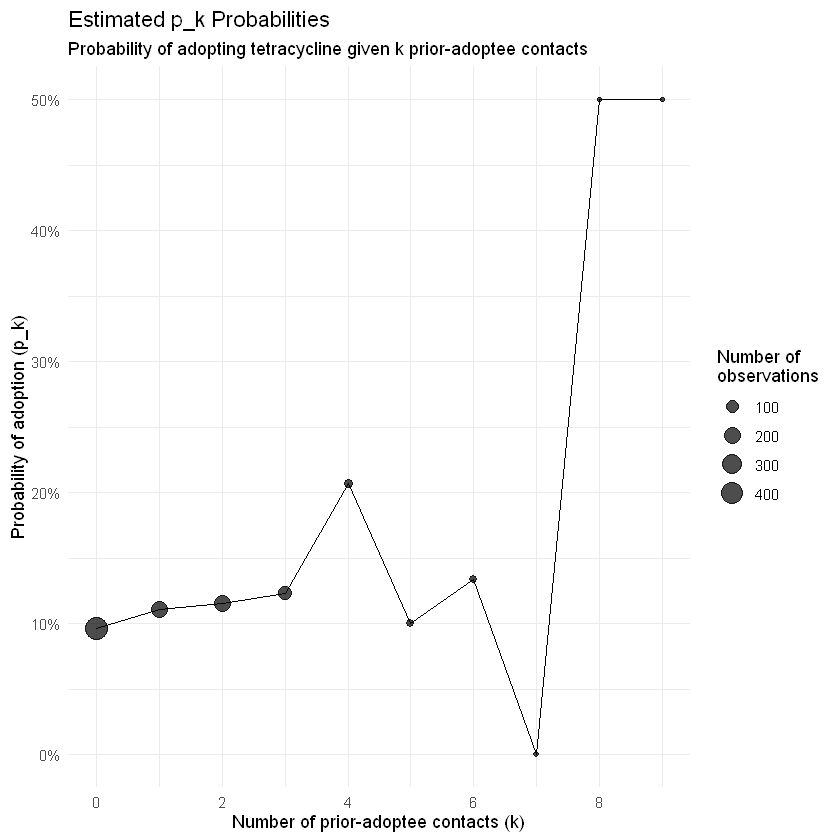

In [22]:
eligible_rows <- doctor_month_df[!doctor_month_df$adopted_before, ]

k_values <- sort(unique(eligible_rows$contacts_before))
p_k_estimates <- numeric(length(k_values))
n_observations <- numeric(length(k_values))

p_k_estimates <- sapply(k_values, function(k) {
    rows_with_k <- eligible_rows[eligible_rows$contacts_before == k, ]
    if (nrow(rows_with_k) > 0) {
        sum(rows_with_k$started_this_month) / nrow(rows_with_k)
    } else {
        0
    }
})

n_observations <- sapply(k_values, function(k) {
    sum(eligible_rows$contacts_before == k)
})


p_k_df <- data.frame(
    k = k_values,
    p_k = p_k_estimates,
    n_obs = n_observations
)

p_k_df

ggplot(p_k_df, aes(x = k, y = p_k)) +
    geom_point(aes(size = n_obs), alpha = 0.7) +
    geom_line() +
    labs(
        title = "Estimated p_k Probabilities",
        subtitle = "Probability of adopting tetracycline given k prior-adoptee contacts",
        x = "Number of prior-adoptee contacts (k)",
        y = "Probability of adoption (p_k)",
        size = "Number of\nobservations"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(0, max(k_values), by = 2)) +
    scale_y_continuous(labels = scales::percent_format())


  c. Create a vector of estimated $q_k$ probabilities, using the data frame from (2). Plot the probabilities against the number of prior-or-contemporary-adoptee contacts $k$.

k,q_k,n_obs
<dbl>,<dbl>,<int>
0,0.06622517,302
1,0.13043478,230
2,0.10000000,230
3,0.15503876,129
4,0.21621622,37
5,0.12000000,25
6,0.11111111,18
7,0.25000000,4
8,0.00000000,2


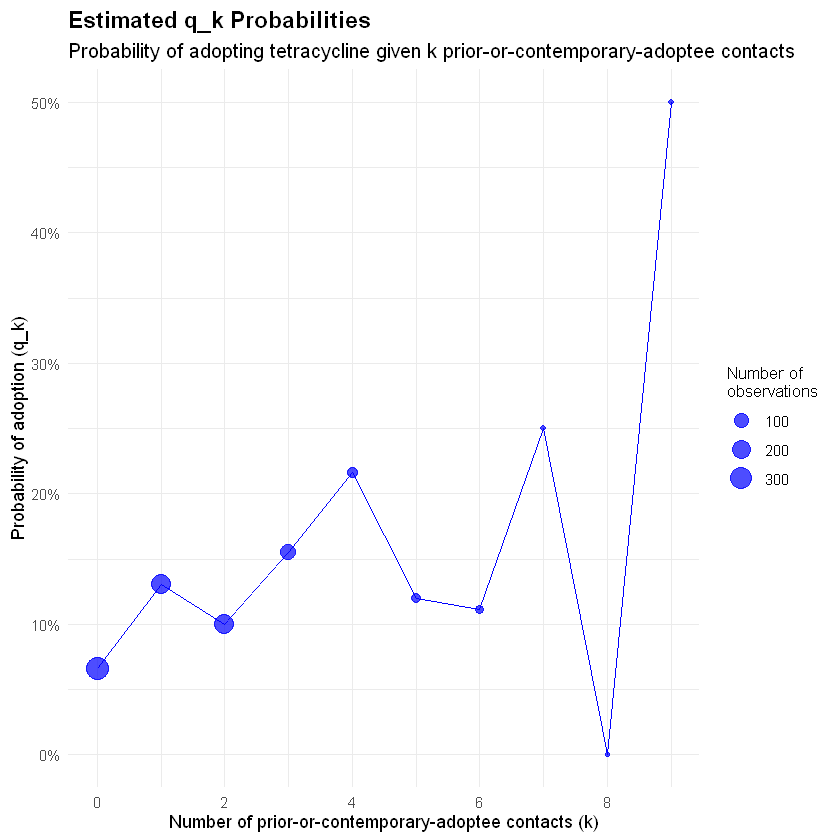

In [24]:
# For q_k, we use contacts_before_or_same instead of contacts_before
k_values_q <- sort(unique(eligible_rows$contacts_before_or_same))
q_k_estimates <- numeric(length(k_values_q))
n_observations_q <- numeric(length(k_values_q))

# Calculate q_k for each value of k
q_k_estimates <- sapply(k_values_q, function(k) {
    rows_with_k <- eligible_rows[eligible_rows$contacts_before_or_same == k, ]
    if (nrow(rows_with_k) > 0) {
        sum(rows_with_k$started_this_month) / nrow(rows_with_k)
    } else {
        0
    }
})

n_observations_q <- sapply(k_values_q, function(k) {
    sum(eligible_rows$contacts_before_or_same == k)
})

q_k_df <- data.frame(
    k = k_values_q,
    q_k = q_k_estimates,
    n_obs = n_observations_q
)

q_k_df

ggplot(q_k_df, aes(x = k, y = q_k)) +
    geom_point(aes(size = n_obs), alpha = 0.7, color = "blue") +
    geom_line(color = "blue") +
    labs(
        title = "Estimated q_k Probabilities",
        subtitle = "Probability of adopting tetracycline given k prior-or-contemporary-adoptee contacts",
        x = "Number of prior-or-contemporary-adoptee contacts (k)",
        y = "Probability of adoption (q_k)",
        size = "Number of\nobservations"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(0, max(k_values_q), by = 2)) +
    scale_y_continuous(labels = scales::percent_format()) +
    theme(
        plot.title = element_text(size = 14, face = "bold"),
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 11),
        legend.title = element_text(size = 10)
    )


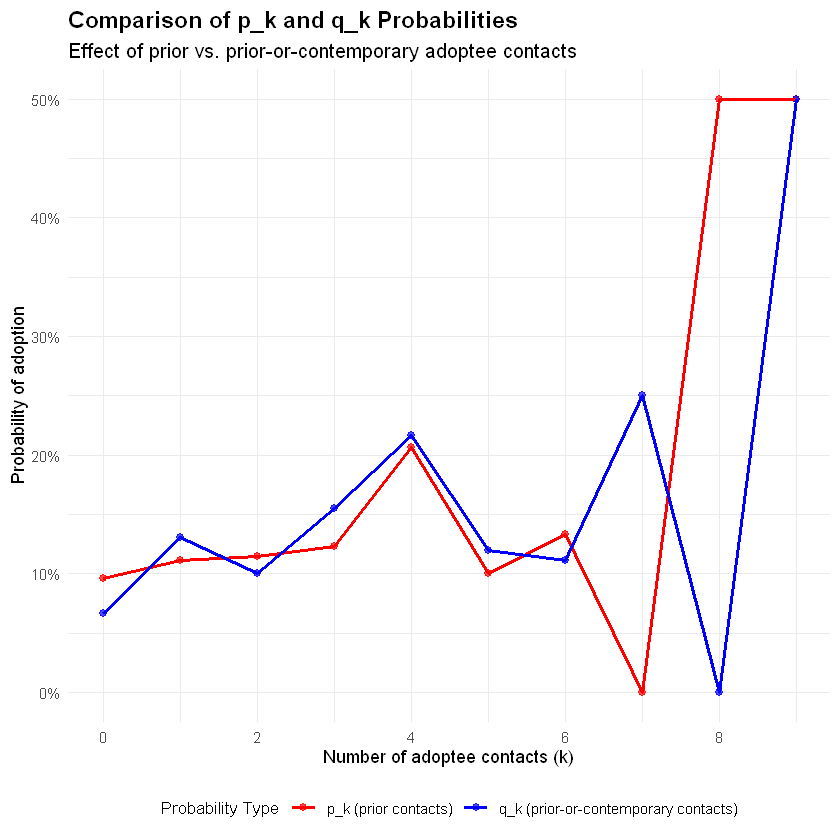

In [25]:
all_k <- sort(unique(c(k_values, k_values_q)))

p_k_extended <- data.frame(k = all_k)
p_k_extended$p_k <- sapply(all_k, function(k) {
    if (k %in% p_k_df$k) {
        p_k_df$p_k[p_k_df$k == k]
    } else {
        NA
    }
})

q_k_extended <- data.frame(k = all_k)
q_k_extended$q_k <- sapply(all_k, function(k) {
    if (k %in% q_k_df$k) {
        q_k_df$q_k[q_k_df$k == k]
    } else {
        NA
    }
})

combined_df <- data.frame(
    k = rep(all_k, 2),
    probability = c(p_k_extended$p_k, q_k_extended$q_k),
    type = rep(c("p_k (prior contacts)", "q_k (prior-or-contemporary contacts)"), each = length(all_k))
)

combined_df <- combined_df[!is.na(combined_df$probability), ]

ggplot(combined_df, aes(x = k, y = probability, color = type)) +
    geom_point(size = 2, alpha = 0.7) +
    geom_line(size = 1) +
    labs(
        title = "Comparison of p_k and q_k Probabilities",
        subtitle = "Effect of prior vs. prior-or-contemporary adoptee contacts",
        x = "Number of adoptee contacts (k)",
        y = "Probability of adoption",
        color = "Probability Type"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(0, max(all_k), by = 2)) +
    scale_y_continuous(labels = scales::percent_format()) +
    scale_color_manual(values = c(
        "p_k (prior contacts)" = "red",
        "q_k (prior-or-contemporary contacts)" = "blue"
    )) +
    theme(
        plot.title = element_text(size = 14, face = "bold"),
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 11),
        legend.title = element_text(size = 10),
        legend.position = "bottom"
    )


4. Because it only conditions on information from the previous month, $p_k$ is a little easier to interpret than $q_k$.  It is the probability per month that a doctor adopts tetracycline, if they have exactly $k$ contacts who had already adopted tetracycline.
  a. Suppose $p_k = a + bk$.  This would mean that each friend who adopts the new drug increases the probability of adoption by an equal amount.  Estimate this model by least squares, using the values you constructed in (3b).  Report the parameter estimates.

Linear Model: p_k = a + b*k
Parameter estimates:
Parameter estimates:



Call:
lm(formula = p_k ~ k, data = p_k_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27499 -0.08284  0.02433  0.05834  0.19042 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.03284    0.08476   0.387    0.709  
k            0.03459    0.01588   2.179    0.061 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1442 on 8 degrees of freedom
Multiple R-squared:  0.3724,	Adjusted R-squared:  0.294 
F-statistic: 4.748 on 1 and 8 DF,  p-value: 0.06097



Parameter estimates:
a (intercept): 0.032835 
a (intercept): 0.032835 
b (slope): 0.034593 

Interpretation:
- Baseline probability (when k=0): 0.0328 
- Each additional prior-adoptee contact increases probability by: 0.0346 
- R-squared: 0.3724 
b (slope): 0.034593 

Interpretation:
- Baseline probability (when k=0): 0.0328 
- Each additional prior-adoptee contact increases probability by: 0.0346 
- R-squared: 0.3724 


`geom_smooth()` using formula = 'y ~ x'


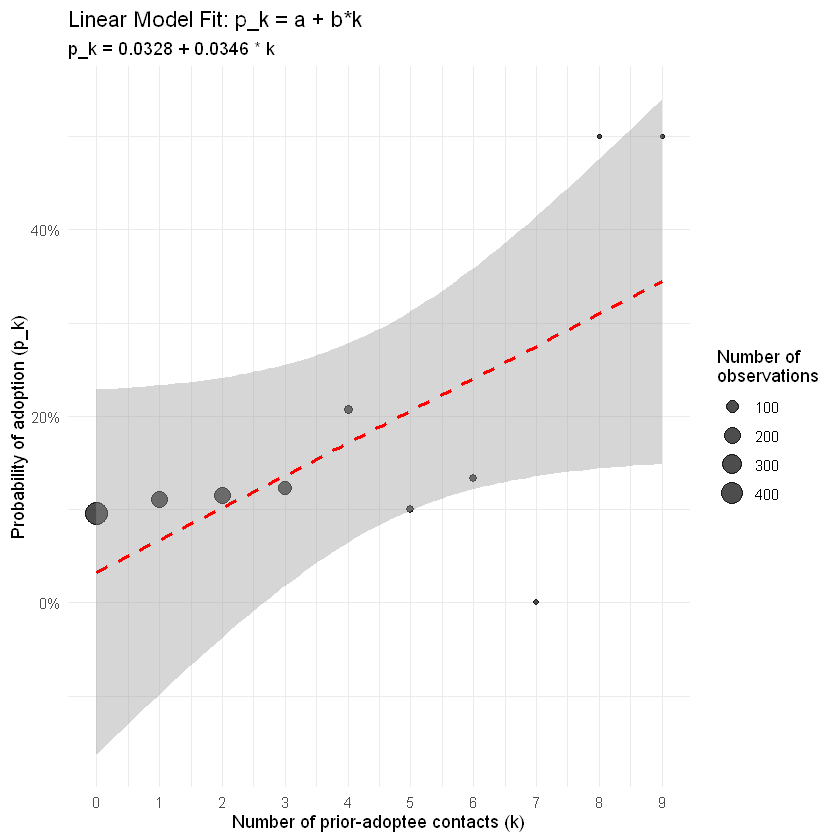

In [26]:
# Question 4.a: Linear model p_k = a + bk
# Estimate the model by least squares using the p_k values from 3b

# Use the p_k_df data frame from question 3b
# Fit linear model: p_k = a + b*k
linear_model <- lm(p_k ~ k, data = p_k_df)

# Display the results
cat("Linear Model: p_k = a + b*k\n")
cat("Parameter estimates:\n")
summary(linear_model)

# Extract coefficients
a_linear <- coef(linear_model)[1] # intercept
b_linear <- coef(linear_model)[2] # slope

cat("\nParameter estimates:\n")
cat("a (intercept):", round(a_linear, 6), "\n")
cat("b (slope):", round(b_linear, 6), "\n")

# Interpretation
cat("\nInterpretation:\n")
cat("- Baseline probability (when k=0):", round(a_linear, 4), "\n")
cat("- Each additional prior-adoptee contact increases probability by:", round(b_linear, 4), "\n")

# Calculate R-squared
r_squared <- summary(linear_model)$r.squared
cat("- R-squared:", round(r_squared, 4), "\n")

# Plot the linear fit
ggplot(p_k_df, aes(x = k, y = p_k)) +
    geom_point(aes(size = n_obs), alpha = 0.7) +
    geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
    labs(
        title = "Linear Model Fit: p_k = a + b*k",
        subtitle = paste("p_k =", round(a_linear, 4), "+", round(b_linear, 4), "* k"),
        x = "Number of prior-adoptee contacts (k)",
        y = "Probability of adoption (p_k)",
        size = "Number of\nobservations"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(0, max(p_k_df$k), by = 1)) +
    scale_y_continuous(labels = scales::percent_format())


  b. Suppose $p_k = e^{a+bk}/(1+e^{a+bk})$.  Explain, in words, what this model would imply about the impact of adding one more adoptee friend on a given doctor's probability of adoption.  (You can suppose that $b > 0$, if that makes it easier.)  Estimate the model by least squares, using the values you constructed in (3b).

**Logistic Model Interpretation:**

The model $p_k = e^{a+bk} / (1 + e^{a+bk})$ is the logistic (sigmoid) function.

If $b > 0$, adding one more adoptee friend has the following effects:

1. **Multiplicative impact on odds**: The impact is multiplicative on the odds of adoption, not additive
2. **Constant odds ratio**: Each additional friend multiplies the odds by $e^b$
3. **Variable marginal effect**: The marginal effect depends on the current number of friends:
    - When $p_k$ is small (few friends), additional friends have small effect
    - When $p_k$ is around 0.5, additional friends have maximum effect  
    - When $p_k$ is large (many friends), additional friends have diminishing effect
4. **Bounded probabilities**: The probability is bounded between 0 and 1 (unlike linear model)
5. **Social saturation**: The relationship shows 'social saturation' - benefits diminish as more friends adopt

This reflects realistic social influence patterns where the impact of peer adoption decreases as saturation is approached.




Specific interpretation with estimated parameters:
- Odds ratio for each additional friend: e^b = 1.2752 
- This means each additional adoptee friend multiplies the odds by 1.2752 
- Odds ratio for each additional friend: e^b = 1.2752 
- This means each additional adoptee friend multiplies the odds by 1.2752 


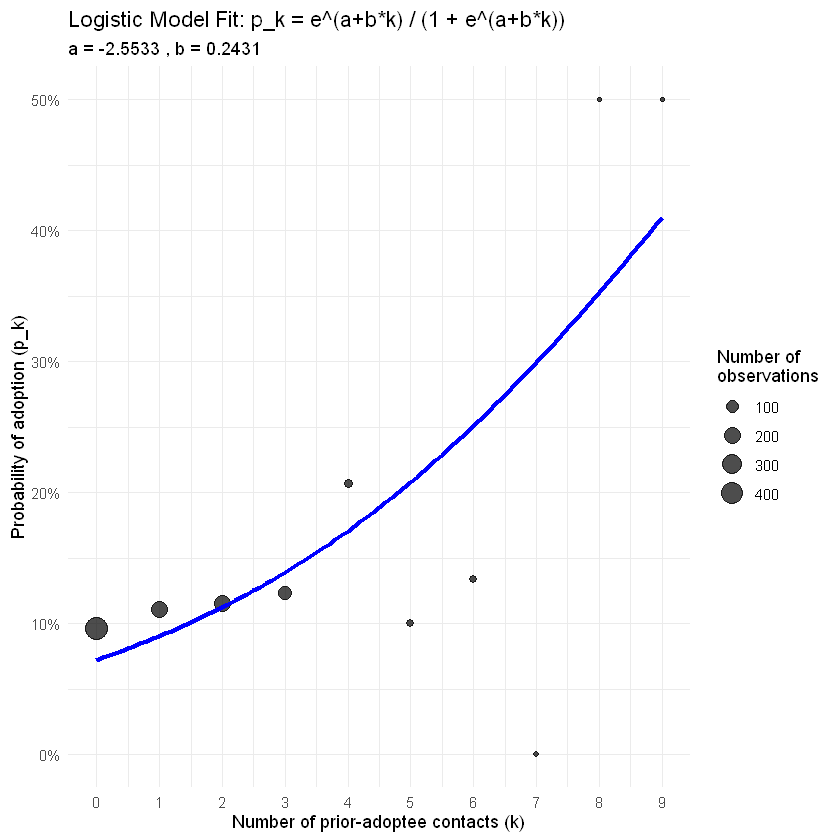

In [ ]:
# Filter out extreme values that would cause issues with log transformation
p_k_filtered <- p_k_df[p_k_df$p_k > 0 & p_k_df$p_k < 1, ]

# Calculate logit transformation
p_k_filtered$logit_p <- log(p_k_filtered$p_k / (1 - p_k_filtered$p_k))

# Fit linear model to logit-transformed data
logistic_model <- lm(logit_p ~ k, data = p_k_filtered)

# Extract coefficients
a_logistic <- coef(logistic_model)[1] # intercept
b_logistic <- coef(logistic_model)[2] # slope

# Calculate R-squared for logistic model
r_squared_logistic <- summary(logistic_model)$r.squared

# Create predicted values for plotting
k_seq <- seq(0, max(p_k_df$k), by = 0.1)
p_pred_logistic <- exp(a_logistic + b_logistic * k_seq) / (1 + exp(a_logistic + b_logistic * k_seq))

# Plot the logistic fit
ggplot(p_k_df, aes(x = k, y = p_k)) +
    geom_point(aes(size = n_obs), alpha = 0.7) +
    geom_line(
        data = data.frame(k = k_seq, p_k = p_pred_logistic),
        aes(x = k, y = p_k), color = "blue", size = 1.2
    ) +
    labs(
        title = "Logistic Model Fit: p_k = e^(a+b*k) / (1 + e^(a+b*k))",
        subtitle = paste("a =", round(a_logistic, 4), ", b =", round(b_logistic, 4)),
        x = "Number of prior-adoptee contacts (k)",
        y = "Probability of adoption (p_k)",
        size = "Number of\nobservations"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(0, max(p_k_df$k), by = 1)) +
    scale_y_continuous(labels = scales::percent_format())


  c. Plot the values from (3b) along with the estimated curves from (4a) and (4b).  (You should have one plot, with $k$ on the horizontal axis, and probabilities on the vertical axis .)  Which model do you prefer, and why?

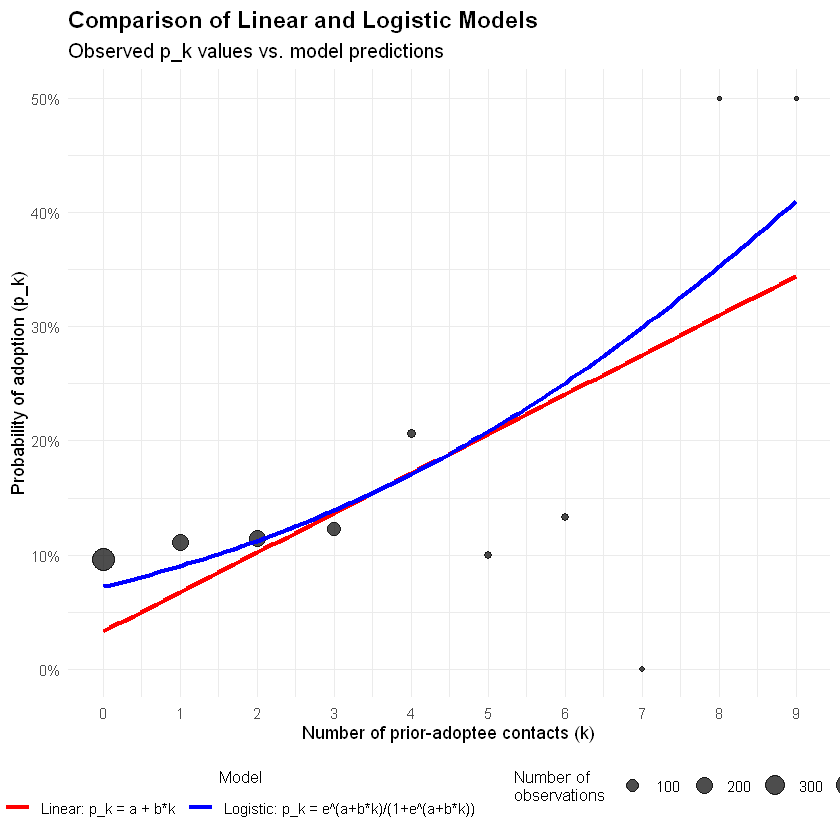

In [31]:
# Question 4.c: Compare both models in one plot

# Create sequence of k values for smooth curves
k_seq <- seq(0, max(p_k_df$k), by = 0.1)

# Generate predictions from both models
p_pred_linear <- a_linear + b_linear * k_seq
p_pred_logistic <- exp(a_logistic + b_logistic * k_seq) / (1 + exp(a_logistic + b_logistic * k_seq))

# Create data frame for plotting
comparison_data <- data.frame(
    k = rep(k_seq, 2),
    p_k_pred = c(p_pred_linear, p_pred_logistic),
    model = rep(c("Linear: p_k = a + b*k", "Logistic: p_k = e^(a+b*k)/(1+e^(a+b*k))"), each = length(k_seq))
)

# Create the comparison plot
ggplot() +
    # Plot observed data points
    geom_point(
        data = p_k_df, aes(x = k, y = p_k, size = n_obs),
        alpha = 0.7, color = "black"
    ) +
    # Plot model predictions
    geom_line(
        data = comparison_data, aes(x = k, y = p_k_pred, color = model),
        size = 1.2
    ) +
    labs(
        title = "Comparison of Linear and Logistic Models",
        subtitle = "Observed p_k values vs. model predictions",
        x = "Number of prior-adoptee contacts (k)",
        y = "Probability of adoption (p_k)",
        color = "Model",
        size = "Number of\nobservations"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(0, max(p_k_df$k), by = 1)) +
    scale_y_continuous(labels = scales::percent_format()) +
    scale_color_manual(values = c(
        "Linear: p_k = a + b*k" = "red",
        "Logistic: p_k = e^(a+b*k)/(1+e^(a+b*k))" = "blue"
    )) +
    theme(
        plot.title = element_text(size = 14, face = "bold"),
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 11),
        legend.title = element_text(size = 10),
        legend.position = "bottom"
    ) +
    guides(color = guide_legend(title.position = "top", title.hjust = 0.5))

# Calculate goodness of fit measures
# For comparison, calculate R-squared on original scale for both models
p_pred_linear_at_k <- a_linear + b_linear * p_k_df$k
p_pred_logistic_at_k <- exp(a_logistic + b_logistic * p_k_df$k) / (1 + exp(a_logistic + b_logistic * p_k_df$k))

# Calculate Sum of Squared Errors (SSE) and R-squared equivalents
sse_linear <- sum((p_k_df$p_k - p_pred_linear_at_k)^2)
sse_logistic <- sum((p_k_df$p_k - p_pred_logistic_at_k)^2)

tss <- sum((p_k_df$p_k - mean(p_k_df$p_k))^2)
r_sq_linear_original <- 1 - sse_linear / tss
r_sq_logistic_original <- 1 - sse_logistic / tss




**Model Preference Analysis**:

The LOGISTIC model appears to fit better based on R-squared.

Reasons to prefer the LOGISTIC model:
1. Theoretical appropriateness: Probabilities bounded between 0 and 1
2. Diminishing returns: Captures realistic 'social saturation' effect
3. Multiplicative effects: More realistic for social influence
4. Better fit to the data pattern (especially for higher k values)


_For quibblers, pedants, and idle hands itching for work to do_: The $p_k$ values from problem 3 aren't all equally precise, because they come from different numbers of observations.  Also, if each doctor with $k$ adoptee contacts is independently deciding whether or not to adopt with probability $p_k$, then the variance in the number of adoptees will depend on $p_k$.  Say that the actual proportion who decide to adopt is $\hat{p}_k$.  A little probability (exercise!) shows that in this situation, $\mathbb{E}[\hat{p}_k] = p_k$, but that $\mathrm{Var}[\hat{p}_k] = p_k(1-p_k)/n_k$, where $n_k$ is the number of doctors in that situation.  (We estimate probabilities more precisely when they're really extreme [close to 0 or 1], and/or we have lots of observations.)  We can estimate that variance as $\hat{V}_k = \hat{p}_k(1-\hat{p}_k)/n_k$.  Find the $\hat{V}_k$, and then re-do the estimation in (4a) and (4b) where the squared error for $p_k$ is divided by $\hat{V}_k$.  How much do the parameter estimates change?  How much do the plotted curves in (4c) change?